# ICU Cohort Analysis: Complete Pipeline

This notebook creates a comprehensive dataset of adult ICU stays ≥48 hours, enriched with:
- Laboratory data (sodium, creatinine)
- Medication administration (vasoactives, sedatives, paralytics)
- Historical ICD codes (1-year lookback for pre-existing conditions)
- Clinical assessments (RASS, CAM-ICU)

**Workflow:**
1. Create base cohort
2. Add lab aggregations
3. Add medication indicators
4. Add ICD code history (1-year lookback)
5. Add RASS assessments
6. Add CAM-ICU assessments
7. Perform exploratory data analysis

## 1. Setup and Data Loading

In [1]:
# Import required libraries
import pandas as pd
import duckdb
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# Initialize DuckDB connection
conn = duckdb.connect()

# Define data paths
data_path = Path('./data')

# Load all required CLIF tables
print("Loading CLIF tables...")

# Core tables
adt_df = pd.read_parquet(data_path / 'clif_adt.parquet')
hosp_df = pd.read_parquet(data_path / 'clif_hospitalization.parquet')
patient_df = pd.read_parquet(data_path / 'clif_patient.parquet')

# Clinical data tables
labs_df = pd.read_parquet(data_path / 'clif_labs.parquet')
meds_df = pd.read_parquet(data_path / 'clif_medication_admin_continuous.parquet')
assessments_df = pd.read_parquet(data_path / 'clif_patient_assessments.parquet')

# Load diagnoses data
print("Loading diagnoses data...")
diagnoses_df = pd.read_csv(data_path / 'diagnoses_icd.csv.gz', compression='gzip')
# Rename columns to match CLIF naming convention
diagnoses_df = diagnoses_df.rename(columns={'hadm_id': 'hospitalization_id', 'subject_id': 'patient_id'})
print(f"  Diagnoses: {diagnoses_df.shape}")

# Register all tables with DuckDB
conn.register('adt', adt_df)
conn.register('hospitalization', hosp_df)
conn.register('patient', patient_df)
conn.register('labs', labs_df)
conn.register('medications', meds_df)
conn.register('assessments', assessments_df)
conn.register('diagnoses', diagnoses_df)

print(f"\nTables loaded:")
print(f"  ADT: {adt_df.shape}")
print(f"  Hospitalization: {hosp_df.shape}")
print(f"  Patient: {patient_df.shape}")
print(f"  Labs: {labs_df.shape}")
print(f"  Medications: {meds_df.shape}")
print(f"  Assessments: {assessments_df.shape}")
print(f"  Diagnoses: {diagnoses_df.shape}")

Loading CLIF tables...
Loading diagnoses data...
  Diagnoses: (6364488, 5)

Tables loaded:
  ADT: (1458408, 8)
  Hospitalization: (546028, 17)
  Patient: (364627, 11)
  Labs: (44880526, 14)
  Medications: (3555411, 12)
  Assessments: (19389145, 8)
  Diagnoses: (6364488, 5)


## 2. Create Base Cohort: Adult ICU Stays ≥48 Hours

In [3]:
# Create base cohort query
cohort_query = """
WITH icu_stays AS (
    -- Find all ICU stays ≥48 hours
    SELECT 
        hospitalization_id,
        patient_id,
        location_name,
        location_type,
        in_dttm,
        out_dttm,
        date_diff('hour', in_dttm, out_dttm) AS icu_hours,
        date_diff('minute', in_dttm, out_dttm) AS icu_minutes
    FROM adt 
    WHERE location_category = 'icu'
      AND in_dttm IS NOT NULL 
      AND out_dttm IS NOT NULL
      AND date_diff('hour', in_dttm, out_dttm) >= 48
),
adult_icu_cohort AS (
    -- Join with hospitalization and patient data for adults only
    SELECT DISTINCT 
        i.hospitalization_id,
        i.patient_id,
        h.admission_dttm,
        h.discharge_dttm,
        h.age_at_admission,
        i.location_name,
        i.location_type,
        i.in_dttm,
        i.out_dttm,
        i.icu_hours,
        i.icu_minutes,
        -- Patient demographics
        p.race_category,
        p.ethnicity_category,
        p.sex_category,
        p.language_category,
        CASE WHEN p.language_category = 'English' THEN 1 ELSE 0 END as is_english,
        -- Create unique stay_id
        i.hospitalization_id || '_' || strftime(i.in_dttm, '%Y%m%d_%H%M%S') || '_' || i.location_type as stay_id
    FROM icu_stays i
    INNER JOIN hospitalization h ON h.hospitalization_id = i.hospitalization_id
    INNER JOIN patient p ON p.patient_id = h.patient_id
    WHERE h.age_at_admission > 18
)
SELECT * FROM adult_icu_cohort
ORDER BY admission_dttm, in_dttm
"""

# Execute query and create base cohort
base_cohort = conn.execute(cohort_query).df()

print(f"Base cohort created:")
print(f"  Total ICU stays: {len(base_cohort):,}")
print(f"  Unique patients: {base_cohort['patient_id'].nunique():,}")
print(f"  Unique hospitalizations: {base_cohort['hospitalization_id'].nunique():,}")

# Verify unique stay_ids
assert base_cohort['stay_id'].nunique() == len(base_cohort), "Duplicate stay_ids found!"
print(f"  Unique stay_ids: {base_cohort['stay_id'].nunique():,} ✓")

# Register base cohort
conn.register('base_cohort', base_cohort)

Base cohort created:
  Total ICU stays: 47,048
  Unique patients: 33,732
  Unique hospitalizations: 40,391
  Unique stay_ids: 47,048 ✓


In [4]:
# Display cohort characteristics
print("\nICU Location Types:")
print(base_cohort['location_type'].value_counts())

print("\nICU Stay Duration Statistics:")
print(base_cohort['icu_hours'].describe())

print("\nSample of base cohort:")
base_cohort[['stay_id', 'location_type', 'icu_hours', 'age_at_admission', 'sex_category', 'language_category']].head()


ICU Location Types:
surgical_icu       13129
medical_icu        10568
cvicu_icu           8284
general_icu         7030
cardiac_icu         5998
mixed_neuro_icu     2039
Name: location_type, dtype: int64

ICU Stay Duration Statistics:
count    47048.000000
mean       135.256568
std        135.380205
min         48.000000
25%         63.000000
50%         89.000000
75%        149.000000
max       2680.000000
Name: icu_hours, dtype: float64

Sample of base cohort:


,stay_id,location_type,icu_hours,age_at_admission,sex_category,language_category
0,20302177_21091221_102908_cardiac_icu,cardiac_icu,267,82,Male,English
1,20302177_21100109_073747_cardiac_icu,cardiac_icu,98,82,Male,English
2,23864737_21100113_080940_cvicu_icu,cvicu_icu,60,61,Female,English
3,23542772_21100111_235400_surgical_icu,surgical_icu,70,61,Female,English
4,29280967_21100114_170720_cvicu_icu,cvicu_icu,119,83,Male,English


## 3. Add Laboratory Data

In [5]:
# Filter labs for sodium and creatinine during ICU stays
print("Processing laboratory data...")

# Sodium labs during ICU stays
sodium_query = '''
SELECT 
    c.stay_id,
    c.hospitalization_id,
    c.in_dttm,
    c.out_dttm,
    AVG(l.lab_value_numeric) as sodium_mean,
    MEDIAN(l.lab_value_numeric) as sodium_median,
    MIN(l.lab_value_numeric) as sodium_min,
    MAX(l.lab_value_numeric) as sodium_max,
    COUNT(l.lab_value_numeric) as sodium_count
FROM base_cohort c
LEFT JOIN labs l ON c.hospitalization_id = l.hospitalization_id
    AND l.lab_category = 'sodium'
    AND l.lab_result_dttm BETWEEN c.in_dttm AND c.out_dttm
    AND l.lab_value_numeric IS NOT NULL
GROUP BY c.stay_id, c.hospitalization_id, c.in_dttm, c.out_dttm
'''

sodium_agg = conn.execute(sodium_query).df()

# Creatinine labs during ICU stays
creatinine_query = '''
SELECT 
    c.stay_id,
    c.hospitalization_id,
    c.in_dttm,
    c.out_dttm,
    AVG(l.lab_value_numeric) as creatinine_mean,
    MEDIAN(l.lab_value_numeric) as creatinine_median,
    MIN(l.lab_value_numeric) as creatinine_min,
    MAX(l.lab_value_numeric) as creatinine_max,
    COUNT(l.lab_value_numeric) as creatinine_count
FROM base_cohort c
LEFT JOIN labs l ON c.hospitalization_id = l.hospitalization_id
    AND l.lab_category = 'creatinine'
    AND l.lab_result_dttm BETWEEN c.in_dttm AND c.out_dttm
    AND l.lab_value_numeric IS NOT NULL
GROUP BY c.stay_id, c.hospitalization_id, c.in_dttm, c.out_dttm
'''

creatinine_agg = conn.execute(creatinine_query).df()

# Merge lab data with base cohort
cohort_with_labs = base_cohort.copy()

# Merge sodium
cohort_with_labs = cohort_with_labs.merge(
    sodium_agg[['stay_id', 'sodium_mean', 'sodium_median', 'sodium_min', 'sodium_max', 'sodium_count']], 
    on='stay_id', 
    how='left'
)

# Merge creatinine
cohort_with_labs = cohort_with_labs.merge(
    creatinine_agg[['stay_id', 'creatinine_mean', 'creatinine_median', 'creatinine_min', 'creatinine_max', 'creatinine_count']], 
    on='stay_id', 
    how='left'
)

# Fill NaN counts with 0
cohort_with_labs['sodium_count'] = cohort_with_labs['sodium_count'].fillna(0).astype(int)
cohort_with_labs['creatinine_count'] = cohort_with_labs['creatinine_count'].fillna(0).astype(int)

print(f"\nLab data added:")
print(f"  Stays with sodium labs: {(cohort_with_labs['sodium_count'] > 0).sum():,} ({(cohort_with_labs['sodium_count'] > 0).mean()*100:.1f}%)")
print(f"  Stays with creatinine labs: {(cohort_with_labs['creatinine_count'] > 0).sum():,} ({(cohort_with_labs['creatinine_count'] > 0).mean()*100:.1f}%)")
print(f"  Dataset shape: {cohort_with_labs.shape}")

# Register updated dataset
conn.register('cohort_with_labs', cohort_with_labs)

Processing laboratory data...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Lab data added:
  Stays with sodium labs: 46,902 (99.7%)
  Stays with creatinine labs: 46,900 (99.7%)
  Dataset shape: (47048, 27)


## 4. Add Medication Data

In [6]:
# Filter medications to relevant categories and hospitalizations
print("Processing medication data...")

# Get relevant hospitalizations
hosp_ids = base_cohort['hospitalization_id'].unique()

# Filter medications
meds_filtered = meds_df[
    (meds_df['med_group'].isin(['vasoactives', 'sedation', 'paralytics'])) &
    (meds_df['hospitalization_id'].isin(hosp_ids))
].copy()

print(f"  Filtered medications: {len(meds_filtered):,} administrations")
print(f"  Unique medication categories: {meds_filtered['med_category'].nunique()}")

# Register filtered medications
conn.register('meds_filtered', meds_filtered)

# Get unique medication categories
med_categories = sorted(meds_filtered['med_category'].unique())
print(f"\nMedication categories to process:")
for i, med in enumerate(med_categories, 1):
    count = (meds_filtered['med_category'] == med).sum()
    print(f"  {i:2d}. {med}: {count:,} administrations")

Processing medication data...
  Filtered medications: 1,702,347 administrations
  Unique medication categories: 20

Medication categories to process:
   1. angiotensin: 391 administrations
   2. cisatracurium: 21,166 administrations
   3. dexmedetomidine: 146,093 administrations
   4. dobutamine: 11,213 administrations
   5. dopamine: 17,358 administrations
   6. epinephrine: 29,565 administrations
   7. fentanyl: 164,059 administrations
   8. hydromorphone: 15,736 administrations
   9. ketamine: 12,988 administrations
  10. lorazepam: 268 administrations
  11. midazolam: 68,652 administrations
  12. milrinone: 12,008 administrations
  13. morphine: 7,776 administrations
  14. norepinephrine: 463,660 administrations
  15. pentobarbital: 937 administrations
  16. phenylephrine: 275,372 administrations
  17. propofol: 408,648 administrations
  18. rocuronium: 3,131 administrations
  19. vasopressin: 43,124 administrations
  20. vecuronium: 202 administrations


In [7]:
# Create boolean columns for each medication
import re

def clean_med_name(med_name):
    """Convert medication name to clean column name"""
    clean_name = re.sub(r'[^a-zA-Z0-9_]', '_', str(med_name))
    clean_name = re.sub(r'_+', '_', clean_name)
    return f"med_{clean_name.strip('_').lower()}"

# Start with cohort that has labs
cohort_with_meds = cohort_with_labs.copy()

print("\nCreating medication boolean columns...")

# Process each medication category
for med_category in med_categories:
    col_name = clean_med_name(med_category)
    
    # Query to check if medication was given during ICU stay
    med_query = f"""
    SELECT 
        c.stay_id,
        CASE WHEN COUNT(m.admin_dttm) > 0 THEN 1 ELSE 0 END as {col_name}
    FROM cohort_with_labs c
    LEFT JOIN meds_filtered m ON c.hospitalization_id = m.hospitalization_id
        AND m.med_category = '{med_category}'
        AND m.admin_dttm BETWEEN c.in_dttm AND c.out_dttm
    GROUP BY c.stay_id
    """
    
    med_result = conn.execute(med_query).df()
    
    # Merge with main dataset
    cohort_with_meds = cohort_with_meds.merge(
        med_result,
        on='stay_id',
        how='left'
    )
    
    # Fill NaN with 0
    cohort_with_meds[col_name] = cohort_with_meds[col_name].fillna(0).astype(int)
    
    # Show progress
    usage = cohort_with_meds[col_name].sum()
    print(f"  {col_name}: {usage:,} stays ({usage/len(cohort_with_meds)*100:.1f}%)")

print(f"\nMedication data added:")
print(f"  Dataset shape: {cohort_with_meds.shape}")
print(f"  Medication columns added: {len([c for c in cohort_with_meds.columns if c.startswith('med_')])}")

# Register updated dataset
conn.register('cohort_with_meds', cohort_with_meds)


Creating medication boolean columns...
  med_angiotensin: 36 stays (0.1%)
  med_cisatracurium: 1,562 stays (3.3%)
  med_dexmedetomidine: 6,927 stays (14.7%)
  med_dobutamine: 1,069 stays (2.3%)
  med_dopamine: 1,393 stays (3.0%)
  med_epinephrine: 2,547 stays (5.4%)
  med_fentanyl: 12,191 stays (25.9%)
  med_hydromorphone: 921 stays (2.0%)
  med_ketamine: 511 stays (1.1%)
  med_lorazepam: 32 stays (0.1%)
  med_midazolam: 6,171 stays (13.1%)
  med_milrinone: 1,228 stays (2.6%)
  med_morphine: 1,545 stays (3.3%)
  med_norepinephrine: 12,477 stays (26.5%)
  med_pentobarbital: 70 stays (0.1%)
  med_phenylephrine: 11,739 stays (25.0%)
  med_propofol: 19,264 stays (40.9%)
  med_rocuronium: 272 stays (0.6%)
  med_vasopressin: 4,502 stays (9.6%)
  med_vecuronium: 33 stays (0.1%)

Medication data added:
  Dataset shape: (47048, 47)
  Medication columns added: 20


## 5. Add ICD Code History (1-Year Lookback)

This section adds flags for pre-existing conditions based on ICD codes from hospitalizations in the year prior to ICU admission.

In [8]:
# Define ICD code mappings for all conditions
print("Defining ICD code mappings for pre-existing conditions...")

icd_mappings = {
    'hx_alzheimers': {
        'icd9': ['331.0'],
        'icd10': ['G30', 'G30.0', 'G30.1', 'G30.9']
    },
    'hx_alcohol_disorder': {
        'icd9': ['291', '292'],
        'icd10': ['F10']
    },
    'hx_opioid_disorder': {
        'icd9': ['304'],
        'icd10': ['F11']
    },
    'hx_cannabis_disorder': {
        'icd9': ['304'],
        'icd10': ['F12']
    },
    'hx_sedative_disorder': {
        'icd9': ['292'],
        'icd10': ['F13']
    },
    'hx_cocaine_disorder': {
        'icd9': ['304'],
        'icd10': ['F14']
    },
    'hx_stimulant_disorder': {
        'icd9': ['304'],
        'icd10': ['F15']
    },
    'hx_hallucinogen_disorder': {
        'icd9': ['304'],
        'icd10': ['F16']
    },
    'hx_dementia': {
        'icd9': ['294.1'],
        'icd10': ['F01', 'F02', 'F03', 'F06']
    },
    'hx_deaf': {
        'icd9': ['389'],
        'icd10': ['H53']
    },
    'hx_blind': {
        'icd9': ['369'],
        'icd10': ['H91']
    },
    'hx_stroke': {
        'icd9': ['436', '438'],
        'icd10': ['I63', 'I69']
    },
    'hx_schizophrenia': {
        'icd9': ['295'],
        'icd10': ['F20', 'F21', 'F22', 'F23', 'F24', 'F25', 'F28', 'F29']
    }
}

# Note: ICD-9 code 304 maps to multiple substance disorders
# We'll need special handling for this
print(f"Defined mappings for {len(icd_mappings)} conditions")
print("\nConditions to track:")
for condition in icd_mappings.keys():
    print(f"  - {condition}")

Defining ICD code mappings for pre-existing conditions...
Defined mappings for 13 conditions

Conditions to track:
  - hx_alzheimers
  - hx_alcohol_disorder
  - hx_opioid_disorder
  - hx_cannabis_disorder
  - hx_sedative_disorder
  - hx_cocaine_disorder
  - hx_stimulant_disorder
  - hx_hallucinogen_disorder
  - hx_dementia
  - hx_deaf
  - hx_blind
  - hx_stroke
  - hx_schizophrenia


In [9]:
# Create historical lookback query
print("Creating 1-year lookback for ICD codes...")

# First, get all hospitalizations with their admission dates for lookback
lookback_query = """
WITH current_stays AS (
    -- Current ICU stays
    SELECT DISTINCT
        c.stay_id,
        c.hospitalization_id as current_hosp_id,
        c.patient_id,
        c.admission_dttm as current_admission
    FROM cohort_with_meds c
),
prior_hospitalizations AS (
    -- Find all prior hospitalizations for each patient
    SELECT 
        cs.stay_id,
        cs.patient_id,
        cs.current_admission,
        h.hospitalization_id as prior_hosp_id,
        h.admission_dttm as prior_admission,
        h.discharge_dttm as prior_discharge
    FROM current_stays cs
    INNER JOIN hospitalization h ON cs.patient_id = h.patient_id
    WHERE h.discharge_dttm < cs.current_admission  -- Prior hospitalizations only
      AND h.discharge_dttm >= cs.current_admission - INTERVAL '1 year'  -- Within 1 year
      AND h.hospitalization_id != cs.current_hosp_id  -- Exclude current hospitalization
),
prior_diagnoses AS (
    -- Get all diagnoses from prior hospitalizations
    SELECT 
        ph.stay_id,
        ph.patient_id,
        d.icd_code,
        d.icd_version,
        d.seq_num
    FROM prior_hospitalizations ph
    INNER JOIN diagnoses d ON ph.prior_hosp_id = d.hospitalization_id
)
SELECT * FROM prior_diagnoses
ORDER BY stay_id, icd_version, icd_code
"""

# Execute query to get historical diagnoses
print("Executing historical lookback query...")
historical_diagnoses = conn.execute(lookback_query).df()

print(f"\nHistorical diagnoses found:")
print(f"  Total diagnosis records: {len(historical_diagnoses):,}")
print(f"  Unique stays with history: {historical_diagnoses['stay_id'].nunique():,}")
print(f"  ICD version distribution:")
print(historical_diagnoses['icd_version'].value_counts())

# Register historical diagnoses
conn.register('historical_diagnoses', historical_diagnoses)

Creating 1-year lookback for ICD codes...
Executing historical lookback query...

Historical diagnoses found:
  Total diagnosis records: 757,226
  Unique stays with history: 17,120
  ICD version distribution:
10    382714
9     374512
Name: icd_version, dtype: int64


In [10]:
# Create functions to check ICD codes
def check_icd_codes(icd_code, icd_list):
    """Check if an ICD code matches any in the list (supports prefix matching)"""
    if pd.isna(icd_code):
        return False
    icd_code = str(icd_code).strip()
    for code in icd_list:
        if icd_code.startswith(code):
            return True
    return False

# Process each condition
print("\nCreating historical condition flags...")
cohort_with_history = cohort_with_meds.copy()

# Initialize all history columns to 0
for condition in icd_mappings.keys():
    cohort_with_history[condition] = 0

# Process historical diagnoses for each condition
for condition, codes in icd_mappings.items():
    print(f"\nProcessing {condition}...")
    
    # Create query to check for this condition in historical data
    icd9_codes = codes['icd9']
    icd10_codes = codes['icd10']
    
    # Build WHERE clause for ICD codes
    where_clauses = []
    
    # ICD-9 codes
    if icd9_codes:
        icd9_conditions = []
        for code in icd9_codes:
            # Handle special case for code 304 (multiple substance disorders)
            if code == '304' and condition in ['hx_opioid_disorder', 'hx_cannabis_disorder', 
                                               'hx_cocaine_disorder', 'hx_stimulant_disorder', 
                                               'hx_hallucinogen_disorder']:
                # Need to look at specific subcodes for substance disorders
                if condition == 'hx_opioid_disorder':
                    icd9_conditions.append("(icd_code LIKE '304.0%')")  # Opioid
                elif condition == 'hx_cannabis_disorder':
                    icd9_conditions.append("(icd_code LIKE '304.3%')")  # Cannabis
                elif condition == 'hx_cocaine_disorder':
                    icd9_conditions.append("(icd_code LIKE '304.2%')")  # Cocaine
                elif condition == 'hx_stimulant_disorder':
                    icd9_conditions.append("(icd_code LIKE '304.4%')")  # Amphetamine
                elif condition == 'hx_hallucinogen_disorder':
                    icd9_conditions.append("(icd_code LIKE '304.5%')")  # Hallucinogen
            else:
                icd9_conditions.append(f"(icd_code LIKE '{code}%')")
        
        if icd9_conditions:
            where_clauses.append(f"(icd_version = 9 AND ({' OR '.join(icd9_conditions)}))")
    
    # ICD-10 codes
    if icd10_codes:
        icd10_conditions = [f"(icd_code LIKE '{code}%')" for code in icd10_codes]
        where_clauses.append(f"(icd_version = 10 AND ({' OR '.join(icd10_conditions)}))")
    
    if where_clauses:
        # Query to find stays with this condition
        condition_query = f"""
        SELECT DISTINCT stay_id
        FROM historical_diagnoses
        WHERE {' OR '.join(where_clauses)}
        """
        
        stays_with_condition = conn.execute(condition_query).df()
        
        # Update the main dataset
        if len(stays_with_condition) > 0:
            cohort_with_history.loc[
                cohort_with_history['stay_id'].isin(stays_with_condition['stay_id']), 
                condition
            ] = 1
            
        print(f"  Found {len(stays_with_condition):,} stays with {condition}")

# Summary of historical conditions
print("\nHistorical condition prevalence:")
history_cols = [col for col in cohort_with_history.columns if col.startswith('hx_')]
for col in history_cols:
    count = cohort_with_history[col].sum()
    pct = (count / len(cohort_with_history)) * 100
    print(f"  {col}: {count:,} stays ({pct:.2f}%)")

print(f"\nDataset shape after adding history: {cohort_with_history.shape}")

# Register updated dataset
conn.register('cohort_with_history', cohort_with_history)


Creating historical condition flags...

Processing hx_alzheimers...
  Found 69 stays with hx_alzheimers

Processing hx_alcohol_disorder...
  Found 1,181 stays with hx_alcohol_disorder

Processing hx_opioid_disorder...
  Found 270 stays with hx_opioid_disorder

Processing hx_cannabis_disorder...
  Found 113 stays with hx_cannabis_disorder

Processing hx_sedative_disorder...
  Found 205 stays with hx_sedative_disorder

Processing hx_cocaine_disorder...
  Found 116 stays with hx_cocaine_disorder

Processing hx_stimulant_disorder...
  Found 27 stays with hx_stimulant_disorder

Processing hx_hallucinogen_disorder...
  Found 3 stays with hx_hallucinogen_disorder

Processing hx_dementia...
  Found 458 stays with hx_dementia

Processing hx_deaf...
  Found 347 stays with hx_deaf

Processing hx_blind...
  Found 335 stays with hx_blind

Processing hx_stroke...
  Found 1,092 stays with hx_stroke

Processing hx_schizophrenia...
  Found 291 stays with hx_schizophrenia

Historical condition prevalen

## 6. Add RASS Assessment Data

In [11]:
# Filter assessments to ICU cohort
print("Processing RASS assessment data...")

# Filter assessments to relevant hospitalizations
assessments_filtered = assessments_df[
    assessments_df['hospitalization_id'].isin(hosp_ids)
].copy()

print(f"  Filtered assessments: {len(assessments_filtered):,} records")
print(f"  Assessment categories: {assessments_filtered['assessment_category'].unique()}")

# Register filtered assessments
conn.register('assessments_filtered', assessments_filtered)

# RASS aggregation query
rass_query = """
SELECT 
    c.stay_id,
    COUNT(a.numerical_value) as rass_count,
    MIN(a.numerical_value) as rass_min,
    MAX(a.numerical_value) as rass_max,
    AVG(a.numerical_value) as rass_mean,
    MEDIAN(a.numerical_value) as rass_median
FROM cohort_with_history c
LEFT JOIN assessments_filtered a ON c.hospitalization_id = a.hospitalization_id
    AND a.assessment_category = 'RASS'
    AND a.recorded_dttm BETWEEN c.in_dttm AND c.out_dttm
    AND a.numerical_value IS NOT NULL
GROUP BY c.stay_id
"""

rass_agg = conn.execute(rass_query).df()

# Merge RASS data
cohort_with_rass = cohort_with_history.merge(
    rass_agg,
    on='stay_id',
    how='left'
)

# Fill count with 0, keep other values as NaN for stays without RASS
cohort_with_rass['rass_count'] = cohort_with_rass['rass_count'].fillna(0).astype(int)

print(f"\nRASS data added:")
print(f"  Stays with RASS assessments: {(cohort_with_rass['rass_count'] > 0).sum():,} ({(cohort_with_rass['rass_count'] > 0).mean()*100:.1f}%)")
print(f"  Dataset shape: {cohort_with_rass.shape}")

# Show RASS statistics for stays with data
rass_stats = cohort_with_rass[cohort_with_rass['rass_count'] > 0]['rass_count'].describe()
print(f"\nRASS assessments per stay (for stays with RASS):")
print(f"  Mean: {rass_stats['mean']:.1f}")
print(f"  Median: {rass_stats['50%']:.0f}")
print(f"  Range: {rass_stats['min']:.0f} - {rass_stats['max']:.0f}")

# Register updated dataset
conn.register('cohort_with_rass', cohort_with_rass)

Processing RASS assessment data...
  Filtered assessments: 15,282,580 records
  Assessment categories: ['gcs_total' 'gcs_motor' 'gcs_verbal' 'gcs_eye' 'RASS' 'braden_activity'
 'braden_friction' 'braden_mobility' 'braden_moisture' 'braden_nutrition'
 'braden_sensory' 'braden_total' 'cam_mental' 'cam_total' 'cam_loc'
 'cam_thinking' 'cam_inattention' 'sbt_delivery_pass_fail'
 'sbt_fail_reason']

RASS data added:
  Stays with RASS assessments: 40,790 (86.7%)
  Dataset shape: (47048, 65)

RASS assessments per stay (for stays with RASS):
  Mean: 30.3
  Median: 20
  Range: 1 - 657


## 7. Add CAM-ICU Assessment Data

In [12]:
# Define CAM categories and their value mappings
print("Processing CAM-ICU assessment data...")

# First, explore what CAM categories exist in the data
cam_categories_query = """
SELECT DISTINCT assessment_category, COUNT(*) as count
FROM assessments_filtered
WHERE assessment_category LIKE 'cam%'
GROUP BY assessment_category
ORDER BY assessment_category
"""

cam_categories_in_data = conn.execute(cam_categories_query).df()
print("\nCAM categories found in data:")
print(cam_categories_in_data)

# Define expected CAM mappings
cam_mappings = {
    'cam_mental': {
        'yes': ['Yes', 'Yes (Continue)'],
        'no': ['No', 'No (Stop - Not delirious)'],
        'unable': ['Unable to Assess', 'Unable to Assess (Stop)']
    },
    'cam_total': {
        'positive': ['Positive'],
        'negative': ['Negative']
    },
    'cam_loc': {
        'yes': ['Yes'],
        'no': ['No']
    },
    'cam_thinking': {
        'yes': ['Yes'],
        'no': ['No'],
        'unable': ['Unable to Assess']
    },
    'cam_inattention': {
        'yes': ['Yes', 'Yes (3 or more errors, then Continue)'],
        'no': ['No', 'No (less than 3 errors - Stop - Not delirious)'],
        'unable': ['Unable to Assess', 'Language Barrier', 'Preexisting Advanced Dementia']
    }
}

Processing CAM-ICU assessment data...

CAM categories found in data:
  assessment_category   count
0     cam_inattention  153380
1             cam_loc  117772
2          cam_mental  394101
3        cam_thinking   27723
4           cam_total  358295


In [13]:
# Create CAM aggregations
cohort_with_cam = cohort_with_rass.copy()
cam_columns_added = []

print("\nCreating CAM-ICU count columns...")

for category, value_map in cam_mappings.items():
    # Check if category exists in data
    if category in cam_categories_in_data['assessment_category'].values:
        print(f"\nProcessing {category}:")
        
        # Build query for this CAM category
        case_statements = []
        for value_type, values in value_map.items():
            col_name = f"{category}_{value_type}_count"
            cam_columns_added.append(col_name)
            
            # Create SQL case statement
            values_str = "', '".join(values)
            case_stmt = f"SUM(CASE WHEN a.categorical_value IN ('{values_str}') THEN 1 ELSE 0 END) as {col_name}"
            case_statements.append(case_stmt)
        
        # Full query for this category
        cam_query = f"""
        SELECT 
            c.stay_id,
            {', '.join(case_statements)}
        FROM cohort_with_cam c
        LEFT JOIN assessments_filtered a ON c.hospitalization_id = a.hospitalization_id
            AND a.assessment_category = '{category}'
            AND a.recorded_dttm BETWEEN c.in_dttm AND c.out_dttm
        GROUP BY c.stay_id
        """
        
        # Execute query
        cam_result = conn.execute(cam_query).df()
        
        # Merge with main dataset
        cols_to_merge = [col for col in cam_result.columns if col != 'stay_id']
        cohort_with_cam = cohort_with_cam.merge(
            cam_result,
            on='stay_id',
            how='left'
        )
        
        # Fill NaN with 0 and convert to int
        for col in cols_to_merge:
            cohort_with_cam[col] = cohort_with_cam[col].fillna(0).astype(int)
            usage = (cohort_with_cam[col] > 0).sum()
            print(f"  {col}: {usage:,} stays have ≥1 assessment")
    else:
        print(f"\nSkipping {category} - not found in data")

print(f"\nCAM-ICU data added:")
print(f"  Dataset shape: {cohort_with_cam.shape}")
print(f"  CAM columns added: {len(cam_columns_added)}")

# Register the final dataset with CAM
conn.register('cohort_with_cam', cohort_with_cam)


Creating CAM-ICU count columns...

Processing cam_mental:
  cam_mental_yes_count: 23,195 stays have ≥1 assessment
  cam_mental_no_count: 32,267 stays have ≥1 assessment
  cam_mental_unable_count: 4,396 stays have ≥1 assessment

Processing cam_total:
  cam_total_positive_count: 17,512 stays have ≥1 assessment
  cam_total_negative_count: 33,315 stays have ≥1 assessment

Processing cam_loc:
  cam_loc_yes_count: 17,294 stays have ≥1 assessment
  cam_loc_no_count: 7,598 stays have ≥1 assessment

Processing cam_thinking:
  cam_thinking_yes_count: 4,766 stays have ≥1 assessment
  cam_thinking_no_count: 3,689 stays have ≥1 assessment
  cam_thinking_unable_count: 509 stays have ≥1 assessment

Processing cam_inattention:
  cam_inattention_yes_count: 18,292 stays have ≥1 assessment
  cam_inattention_no_count: 11,910 stays have ≥1 assessment
  cam_inattention_unable_count: 4,231 stays have ≥1 assessment

CAM-ICU data added:
  Dataset shape: (47048, 78)
  CAM columns added: 13


In [ ]:
# Final dataset
final_dataset = cohort_with_cam.copy()

# Validation
print("=== FINAL DATASET VALIDATION ===")
print(f"\nDataset shape: {final_dataset.shape}")
print(f"Expected rows: 47,048")
print(f"Actual rows: {len(final_dataset):,}")
print(f"Rows preserved: {'✓' if len(final_dataset) == len(base_cohort) else '✗'}")

print(f"\nUnique identifiers:")
print(f"  Stay IDs: {final_dataset['stay_id'].nunique():,}")
print(f"  Patients: {final_dataset['patient_id'].nunique():,}")
print(f"  Hospitalizations: {final_dataset['hospitalization_id'].nunique():,}")

# Column breakdown
base_cols = len(base_cohort.columns)
lab_cols = len([c for c in final_dataset.columns if 'sodium' in c or 'creatinine' in c])
med_cols = len([c for c in final_dataset.columns if c.startswith('med_')])
history_cols = len([c for c in final_dataset.columns if c.startswith('hx_')])
rass_cols = len([c for c in final_dataset.columns if c.startswith('rass_')])
cam_cols = len([c for c in final_dataset.columns if c.startswith('cam_')])

print(f"\nColumn breakdown:")
print(f"  Base cohort columns: {base_cols}")
print(f"  Lab columns: {lab_cols}")
print(f"  Medication columns: {med_cols}")
print(f"  ICD history columns: {history_cols}")
print(f"  RASS columns: {rass_cols}")
print(f"  CAM columns: {cam_cols}")
print(f"  Total columns: {len(final_dataset.columns)}")

# Save final dataset
output_file = 'icu_cohort_complete.parquet'
final_dataset.to_parquet(output_file, index=False)
final_dataset.to_csv('icu_cohort_complete.csv', index=False)
print(f"\n✓ Final dataset saved to: {output_file}")

# Display sample
print("\nSample of final dataset:")
sample_cols = ['stay_id', 'location_type', 'icu_hours', 'age_at_admission', 
               'sodium_mean', 'creatinine_mean', 'med_propofol', 'med_norepinephrine',
               'hx_dementia', 'hx_stroke', 'rass_count', 'cam_total_positive_count']
# Only show columns that exist
sample_cols = [c for c in sample_cols if c in final_dataset.columns]
final_dataset[sample_cols].head()

=== FINAL DATASET VALIDATION ===

Dataset shape: (47048, 78)
Expected rows: 47,048
Actual rows: 47,048
Rows preserved: ✓

Unique identifiers:
  Stay IDs: 47,048
  Patients: 33,732
  Hospitalizations: 40,391

Column breakdown:
  Base cohort columns: 17
  Lab columns: 10
  Medication columns: 20
  ICD history columns: 13
  RASS columns: 5
  CAM columns: 13
  Total columns: 78

✓ Final dataset saved to: icu_cohort_complete.parquet

Sample of final dataset:


,stay_id,location_type,icu_hours,age_at_admission,sodium_mean,creatinine_mean,med_propofol,med_norepinephrine,hx_dementia,hx_stroke,rass_count,cam_total_positive_count
0,20302177_21091221_102908_cardiac_icu,cardiac_icu,267,82,134.264706,3.224242,0,0,0,0,0,0
1,20302177_21100109_073747_cardiac_icu,cardiac_icu,98,82,137.166667,2.666667,0,0,0,0,0,0
2,23864737_21100113_080940_cvicu_icu,cvicu_icu,60,61,136.125000,0.475000,1,0,0,0,6,0
3,23542772_21100111_235400_surgical_icu,surgical_icu,70,61,144.000000,0.600000,1,0,0,0,8,0
4,29280967_21100114_170720_cvicu_icu,cvicu_icu,119,83,140.000000,0.966667,1,0,0,0,20,2


## 8. Final Dataset Validation and Save

## 9. Exploratory Data Analysis

In [15]:
# Set up for visualizations
plt.rcParams['figure.figsize'] = (15, 10)
print("Starting Exploratory Data Analysis...")

Starting Exploratory Data Analysis...


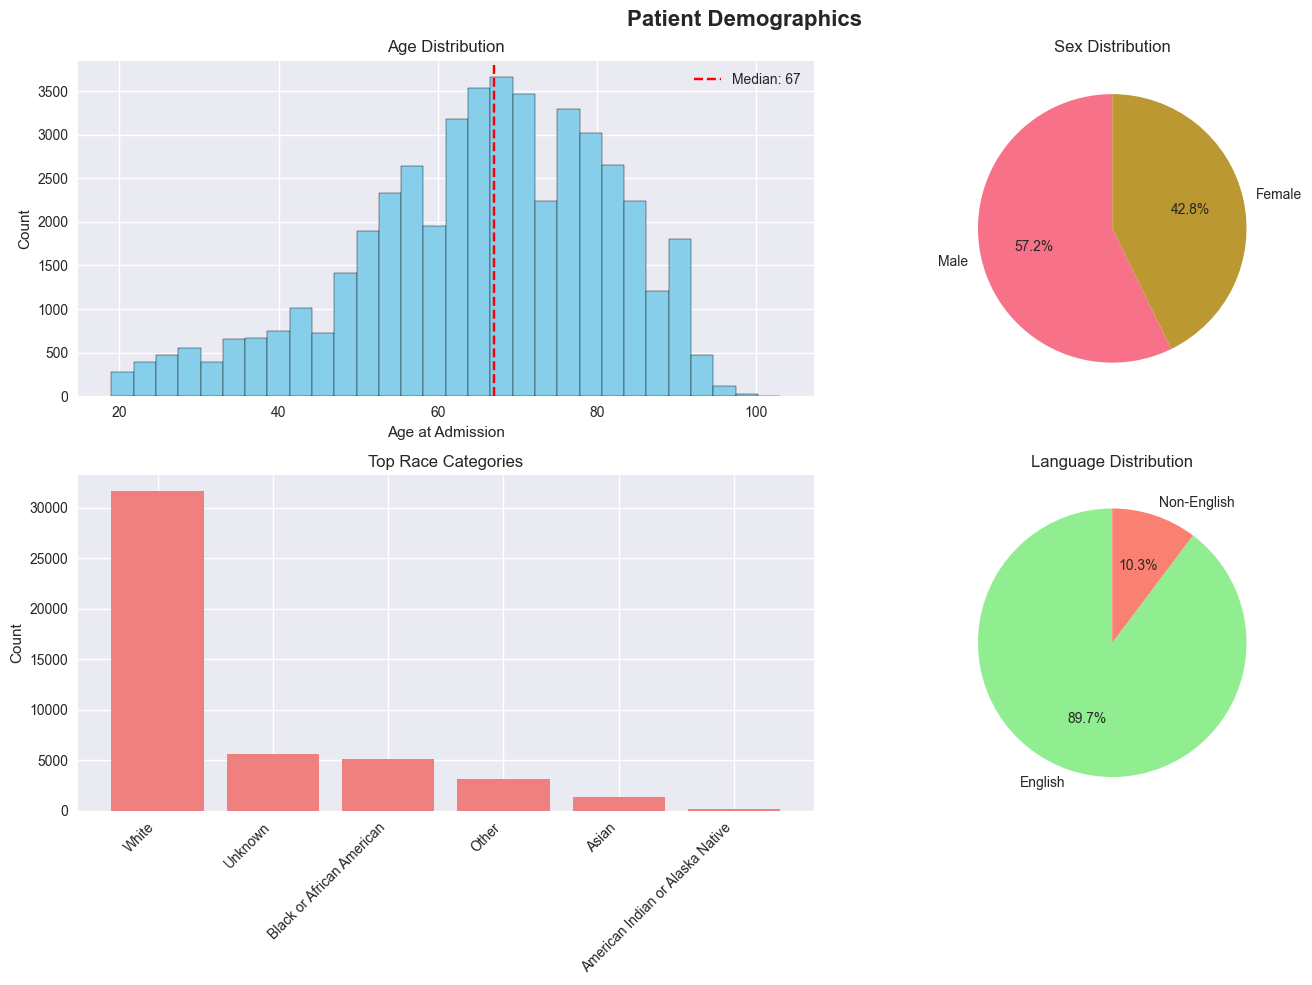

In [16]:
# 1. Demographics Overview
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Patient Demographics', fontsize=16, fontweight='bold')

# Age distribution
ax1 = axes[0, 0]
final_dataset['age_at_admission'].hist(bins=30, ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Age Distribution')
ax1.set_xlabel('Age at Admission')
ax1.set_ylabel('Count')
ax1.axvline(final_dataset['age_at_admission'].median(), color='red', linestyle='--', 
            label=f'Median: {final_dataset["age_at_admission"].median():.0f}')
ax1.legend()

# Sex distribution
ax2 = axes[0, 1]
sex_counts = final_dataset['sex_category'].value_counts()
ax2.pie(sex_counts.values, labels=sex_counts.index, autopct='%1.1f%%', startangle=90)
ax2.set_title('Sex Distribution')

# Race distribution
ax3 = axes[1, 0]
race_counts = final_dataset['race_category'].value_counts().head(6)
ax3.bar(range(len(race_counts)), race_counts.values, color='lightcoral')
ax3.set_xticks(range(len(race_counts)))
ax3.set_xticklabels(race_counts.index, rotation=45, ha='right')
ax3.set_title('Top Race Categories')
ax3.set_ylabel('Count')

# Language distribution
ax4 = axes[1, 1]
english_dist = final_dataset['is_english'].value_counts()
english_labels = ['English', 'Non-English']
ax4.pie(english_dist.values, labels=english_labels, autopct='%1.1f%%', 
        colors=['lightgreen', 'salmon'], startangle=90)
ax4.set_title('Language Distribution')

plt.tight_layout()
plt.show()

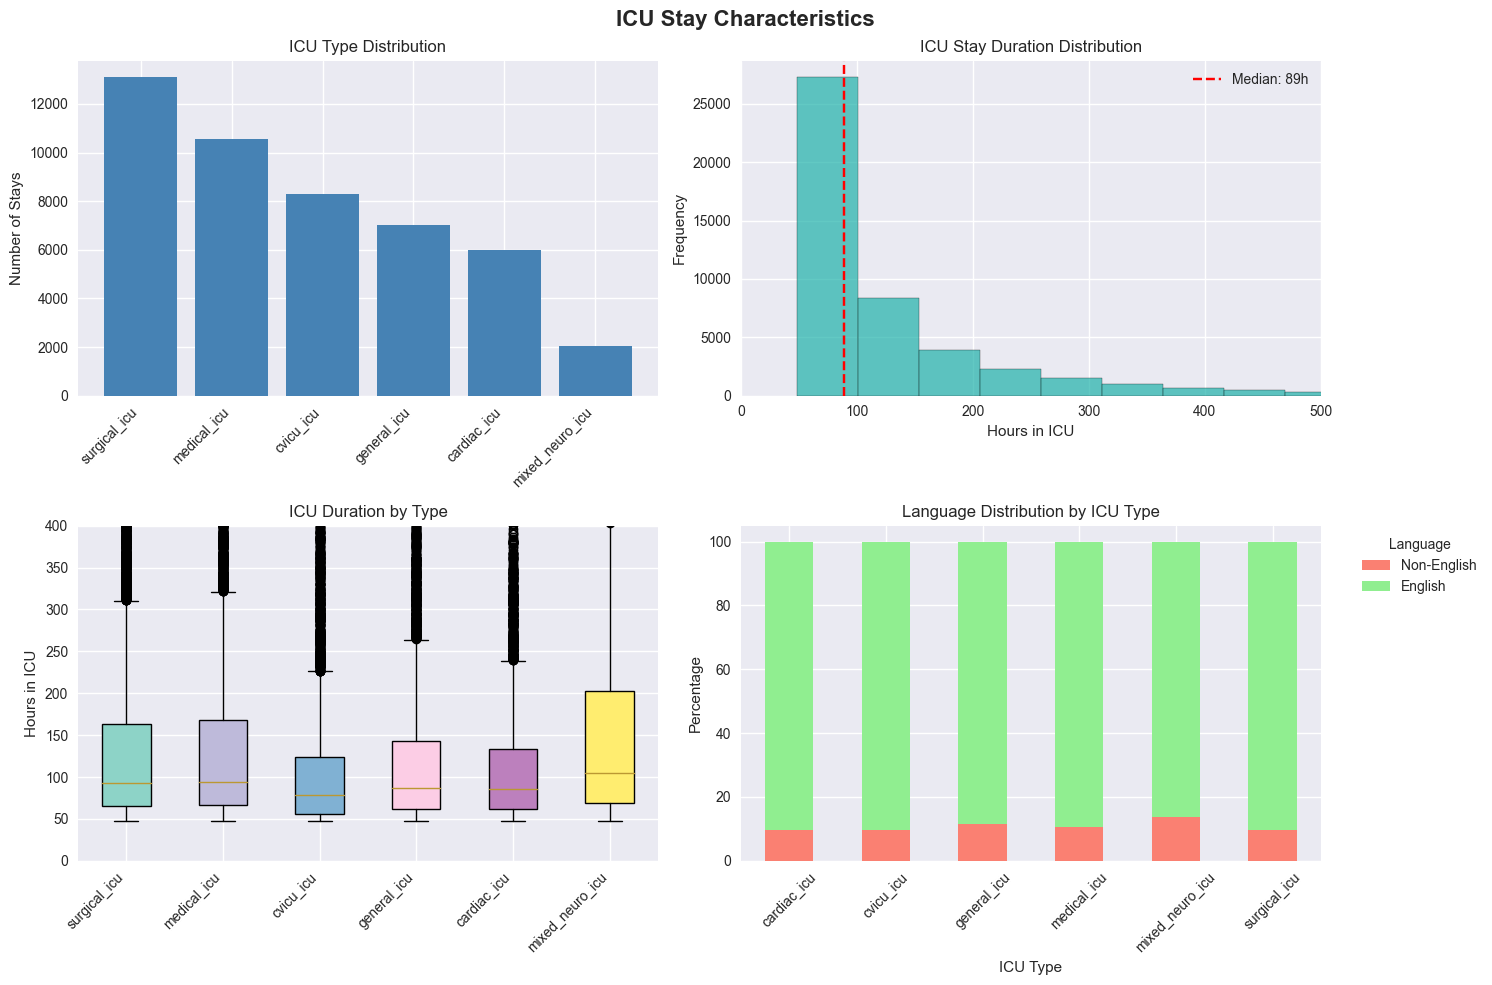

In [17]:
# 2. ICU Stay Characteristics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('ICU Stay Characteristics', fontsize=16, fontweight='bold')

# ICU types distribution
ax1 = axes[0, 0]
icu_counts = final_dataset['location_type'].value_counts()
ax1.bar(range(len(icu_counts)), icu_counts.values, color='steelblue')
ax1.set_xticks(range(len(icu_counts)))
ax1.set_xticklabels(icu_counts.index, rotation=45, ha='right')
ax1.set_title('ICU Type Distribution')
ax1.set_ylabel('Number of Stays')

# ICU duration distribution
ax2 = axes[0, 1]
ax2.hist(final_dataset['icu_hours'], bins=50, color='lightseagreen', edgecolor='black', alpha=0.7)
ax2.set_title('ICU Stay Duration Distribution')
ax2.set_xlabel('Hours in ICU')
ax2.set_ylabel('Frequency')
ax2.axvline(final_dataset['icu_hours'].median(), color='red', linestyle='--', 
            label=f'Median: {final_dataset["icu_hours"].median():.0f}h')
ax2.set_xlim(0, 500)  # Focus on main distribution
ax2.legend()

# ICU duration by type (box plot)
ax3 = axes[1, 0]
icu_order = final_dataset['location_type'].value_counts().index
duration_data = [final_dataset[final_dataset['location_type'] == icu]['icu_hours'] for icu in icu_order]
bp = ax3.boxplot(duration_data, labels=icu_order, patch_artist=True)
ax3.set_xticklabels(icu_order, rotation=45, ha='right')
ax3.set_title('ICU Duration by Type')
ax3.set_ylabel('Hours in ICU')
ax3.set_ylim(0, 400)  # Focus on main distribution
# Color boxes
colors = plt.cm.Set3(np.linspace(0, 1, len(bp['boxes'])))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Language by ICU type
ax4 = axes[1, 1]
lang_by_icu = pd.crosstab(final_dataset['location_type'], final_dataset['is_english'])
lang_by_icu.columns = ['Non-English', 'English']
lang_by_icu_pct = lang_by_icu.div(lang_by_icu.sum(axis=1), axis=0) * 100
lang_by_icu_pct.plot(kind='bar', stacked=True, ax=ax4, color=['salmon', 'lightgreen'])
ax4.set_title('Language Distribution by ICU Type')
ax4.set_xlabel('ICU Type')
ax4.set_ylabel('Percentage')
ax4.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

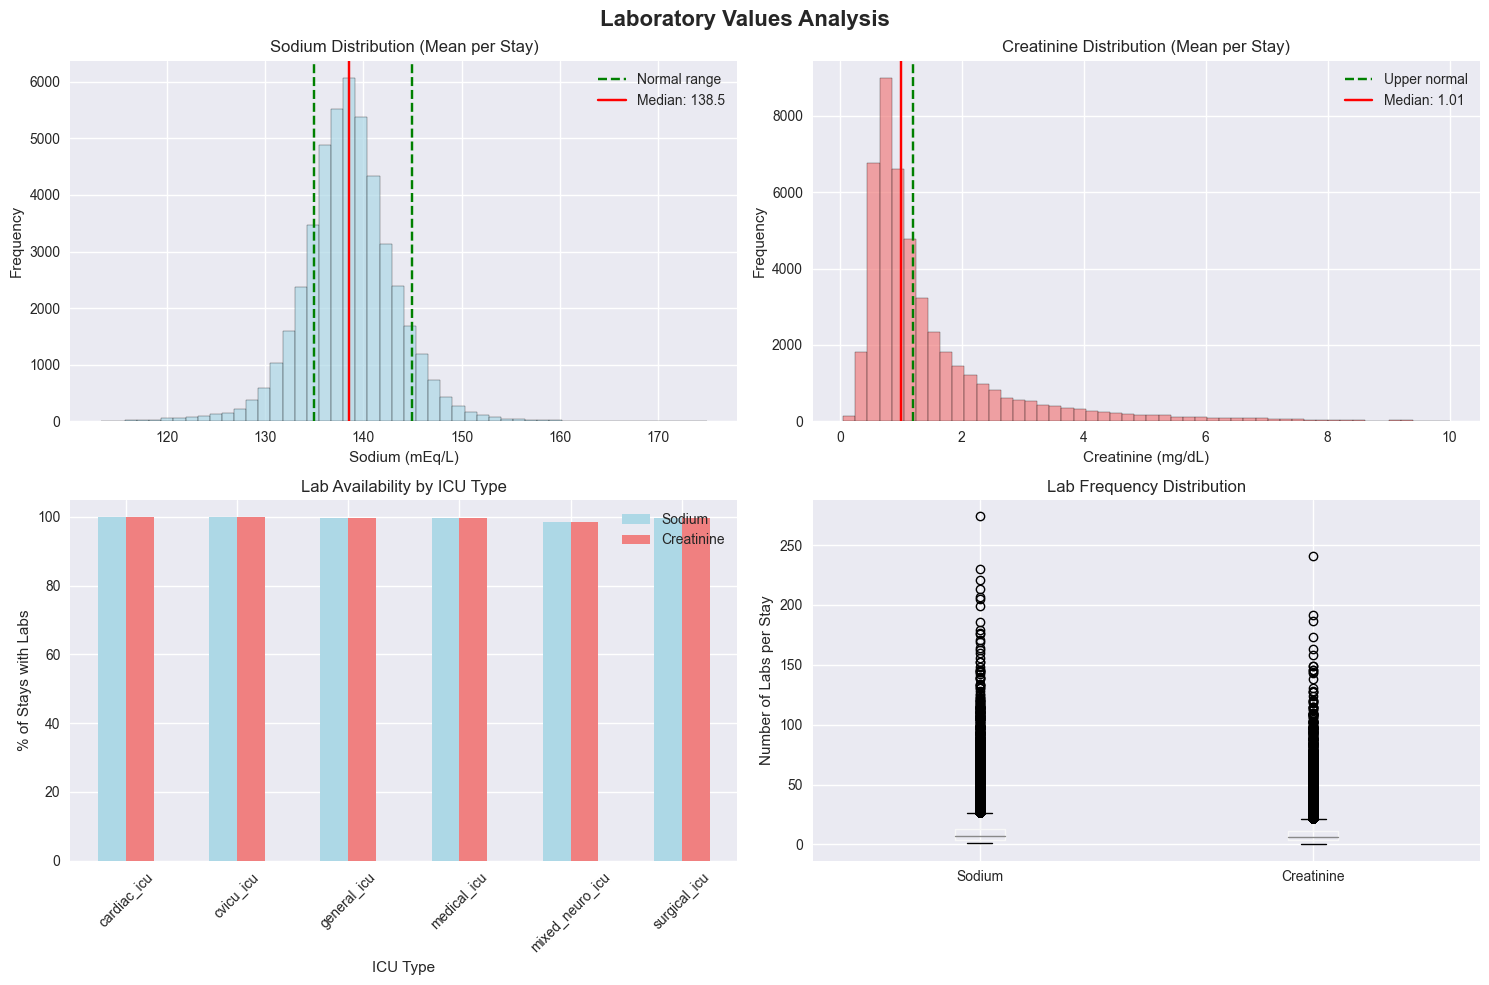

In [18]:
# 3. Laboratory Values Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Laboratory Values Analysis', fontsize=16, fontweight='bold')

# Sodium distribution
ax1 = axes[0, 0]
sodium_data = final_dataset['sodium_mean'].dropna()
if len(sodium_data) > 0:
    ax1.hist(sodium_data, bins=50, color='lightblue', edgecolor='black', alpha=0.7)
    ax1.set_title('Sodium Distribution (Mean per Stay)')
    ax1.set_xlabel('Sodium (mEq/L)')
    ax1.set_ylabel('Frequency')
    ax1.axvline(135, color='green', linestyle='--', label='Normal range')
    ax1.axvline(145, color='green', linestyle='--')
    ax1.axvline(sodium_data.median(), color='red', linestyle='-', 
                label=f'Median: {sodium_data.median():.1f}')
    ax1.legend()

# Creatinine distribution
ax2 = axes[0, 1]
creat_data = final_dataset['creatinine_mean'].dropna()
if len(creat_data) > 0:
    # Limit to reasonable range for visualization
    creat_viz = creat_data[creat_data <= 10]
    ax2.hist(creat_viz, bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
    ax2.set_title('Creatinine Distribution (Mean per Stay)')
    ax2.set_xlabel('Creatinine (mg/dL)')
    ax2.set_ylabel('Frequency')
    ax2.axvline(1.2, color='green', linestyle='--', label='Upper normal')
    ax2.axvline(creat_viz.median(), color='red', linestyle='-', 
                label=f'Median: {creat_viz.median():.2f}')
    ax2.legend()

# Lab availability by ICU type
ax3 = axes[1, 0]
lab_availability = final_dataset.groupby('location_type').agg({
    'sodium_count': lambda x: (x > 0).mean() * 100,
    'creatinine_count': lambda x: (x > 0).mean() * 100
})
lab_availability.plot(kind='bar', ax=ax3, color=['lightblue', 'lightcoral'])
ax3.set_title('Lab Availability by ICU Type')
ax3.set_xlabel('ICU Type')
ax3.set_ylabel('% of Stays with Labs')
ax3.legend(['Sodium', 'Creatinine'])
ax3.tick_params(axis='x', rotation=45)

# Lab frequency distribution
ax4 = axes[1, 1]
lab_counts = final_dataset[['sodium_count', 'creatinine_count']].copy()
lab_counts = lab_counts[lab_counts.max(axis=1) > 0]  # Only stays with labs
if len(lab_counts) > 0:
    lab_counts.boxplot(ax=ax4)
    ax4.set_title('Lab Frequency Distribution')
    ax4.set_ylabel('Number of Labs per Stay')
    ax4.set_xticklabels(['Sodium', 'Creatinine'])

plt.tight_layout()
plt.show()

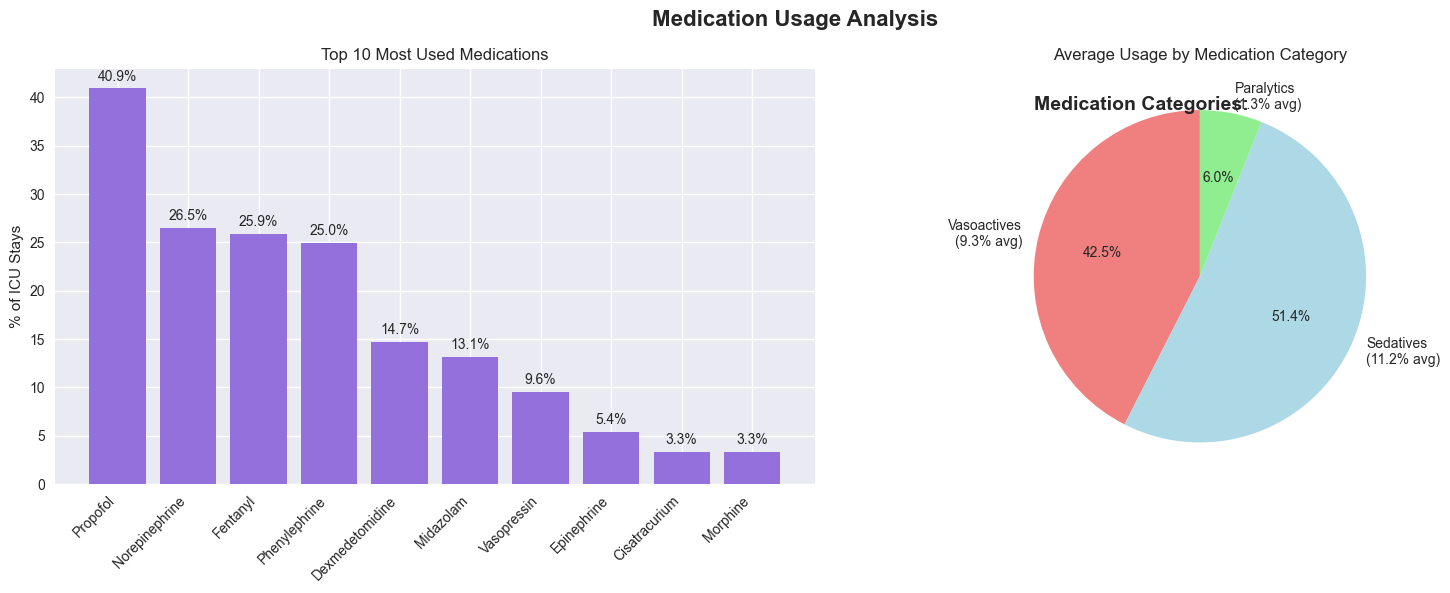

In [19]:
# 4. Medication Usage Analysis
# Get medication columns
med_columns = [col for col in final_dataset.columns if col.startswith('med_')]

if med_columns:
    # Calculate usage percentages
    med_usage = {}
    for col in med_columns:
        usage_pct = (final_dataset[col] == 1).mean() * 100
        med_name = col.replace('med_', '').replace('_', ' ').title()
        med_usage[med_name] = usage_pct
    
    # Sort by usage
    med_usage_sorted = dict(sorted(med_usage.items(), key=lambda x: x[1], reverse=True))
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Medication Usage Analysis', fontsize=16, fontweight='bold')
    
    # Top 10 medications bar chart
    top_meds = list(med_usage_sorted.items())[:10]
    med_names = [m[0] for m in top_meds]
    med_pcts = [m[1] for m in top_meds]
    
    bars = ax1.bar(range(len(med_names)), med_pcts, color='mediumpurple')
    ax1.set_xticks(range(len(med_names)))
    ax1.set_xticklabels(med_names, rotation=45, ha='right')
    ax1.set_title('Top 10 Most Used Medications')
    ax1.set_ylabel('% of ICU Stays')
    
    # Add value labels on bars
    for bar, pct in zip(bars, med_pcts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5, f'{pct:.1f}%',
                ha='center', va='bottom')
    
    # Medication categories
    ax2.text(0.1, 0.9, 'Medication Categories:', fontsize=14, fontweight='bold', 
             transform=ax2.transAxes)
    
    # Count by category
    vasoactives = ['Norepinephrine', 'Phenylephrine', 'Vasopressin', 'Epinephrine', 
                   'Dopamine', 'Milrinone', 'Dobutamine', 'Angiotensin']
    sedatives = ['Propofol', 'Fentanyl', 'Dexmedetomidine', 'Midazolam', 
                 'Hydromorphone', 'Ketamine', 'Morphine', 'Pentobarbital', 'Lorazepam']
    paralytics = ['Cisatracurium', 'Rocuronium', 'Vecuronium']
    
    # Calculate category usage
    vaso_usage = sum(med_usage.get(med, 0) for med in vasoactives) / len(vasoactives)
    sed_usage = sum(med_usage.get(med, 0) for med in sedatives) / len(sedatives)
    para_usage = sum(med_usage.get(med, 0) for med in paralytics) / len(paralytics)
    
    category_data = {
        'Vasoactives': vaso_usage,
        'Sedatives': sed_usage,
        'Paralytics': para_usage
    }
    
    # Pie chart of category usage
    sizes = list(category_data.values())
    labels = [f"{k}\n({v:.1f}% avg)" for k, v in category_data.items()]
    colors = ['lightcoral', 'lightblue', 'lightgreen']
    
    ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Average Usage by Medication Category')
    
    plt.tight_layout()
    plt.show()
else:
    print("No medication columns found in dataset")

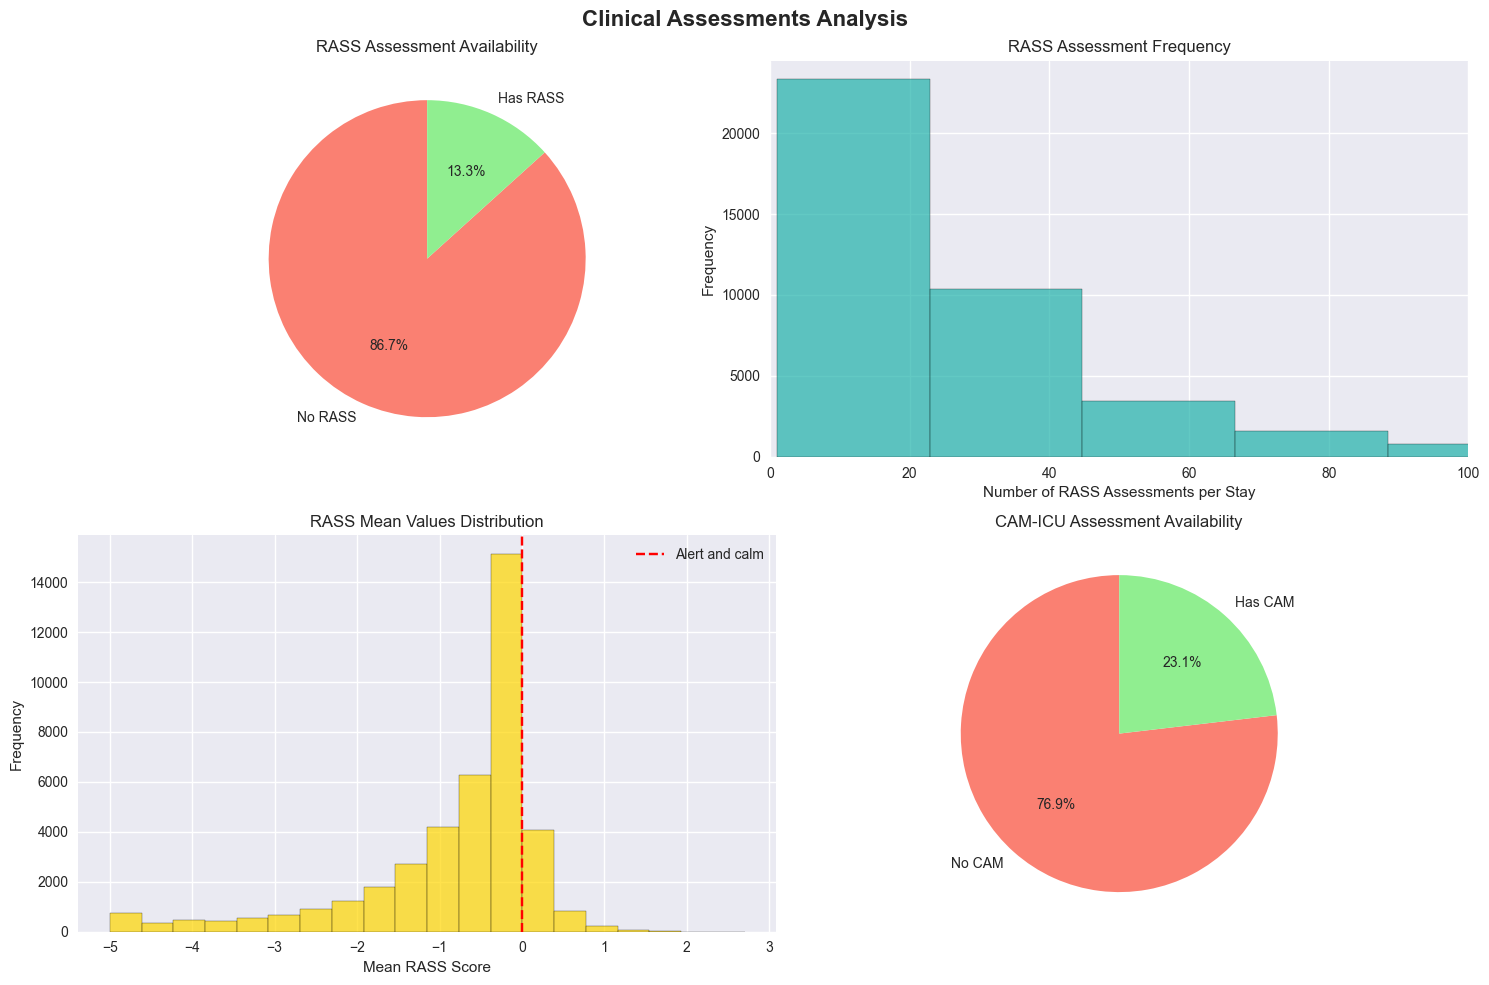

In [20]:
# 5. Clinical Assessments Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Clinical Assessments Analysis', fontsize=16, fontweight='bold')

# RASS availability
ax1 = axes[0, 0]
rass_available = (final_dataset['rass_count'] > 0).value_counts()
ax1.pie(rass_available.values, labels=['No RASS', 'Has RASS'], 
        autopct='%1.1f%%', colors=['salmon', 'lightgreen'], startangle=90)
ax1.set_title('RASS Assessment Availability')

# RASS frequency distribution
ax2 = axes[0, 1]
rass_with_data = final_dataset[final_dataset['rass_count'] > 0]['rass_count']
if len(rass_with_data) > 0:
    ax2.hist(rass_with_data, bins=30, color='lightseagreen', edgecolor='black', alpha=0.7)
    ax2.set_title('RASS Assessment Frequency')
    ax2.set_xlabel('Number of RASS Assessments per Stay')
    ax2.set_ylabel('Frequency')
    ax2.set_xlim(0, min(100, rass_with_data.max()))

# RASS values distribution
ax3 = axes[1, 0]
rass_means = final_dataset['rass_mean'].dropna()
if len(rass_means) > 0:
    ax3.hist(rass_means, bins=20, color='gold', edgecolor='black', alpha=0.7)
    ax3.set_title('RASS Mean Values Distribution')
    ax3.set_xlabel('Mean RASS Score')
    ax3.set_ylabel('Frequency')
    ax3.axvline(0, color='red', linestyle='--', label='Alert and calm')
    ax3.legend()

# CAM assessment summary
ax4 = axes[1, 1]
cam_cols = [col for col in final_dataset.columns if col.startswith('cam_')]
if cam_cols:
    # Count stays with any CAM assessment
    cam_any = (final_dataset[cam_cols].sum(axis=1) > 0).value_counts()
    ax4.pie(cam_any.values, labels=['No CAM', 'Has CAM'], 
            autopct='%1.1f%%', colors=['salmon', 'lightgreen'], startangle=90)
    ax4.set_title('CAM-ICU Assessment Availability')
else:
    ax4.text(0.5, 0.5, 'No CAM data available', ha='center', va='center', 
             transform=ax4.transAxes, fontsize=14)
    ax4.axis('off')

plt.tight_layout()
plt.show()

In [21]:
# 6. Summary Statistics
print("=== COMPREHENSIVE DATASET SUMMARY ===")
print(f"\nTotal ICU stays analyzed: {len(final_dataset):,}")
print(f"Unique patients: {final_dataset['patient_id'].nunique():,}")
print(f"Unique hospitalizations: {final_dataset['hospitalization_id'].nunique():,}")

print("\n--- Demographics ---")
print(f"Age: {final_dataset['age_at_admission'].mean():.1f} ± {final_dataset['age_at_admission'].std():.1f} years")
print(f"Sex distribution: {dict(final_dataset['sex_category'].value_counts())}")
print(f"English speakers: {(final_dataset['is_english'] == 1).mean()*100:.1f}%")

print("\n--- ICU Stay Characteristics ---")
print(f"Mean duration: {final_dataset['icu_hours'].mean():.1f} hours")
print(f"Median duration: {final_dataset['icu_hours'].median():.0f} hours")
print(f"Most common ICU type: {final_dataset['location_type'].mode()[0]}")

print("\n--- Clinical Data Coverage ---")
print(f"Sodium labs: {(final_dataset['sodium_count'] > 0).mean()*100:.1f}% of stays")
print(f"Creatinine labs: {(final_dataset['creatinine_count'] > 0).mean()*100:.1f}% of stays")
print(f"RASS assessments: {(final_dataset['rass_count'] > 0).mean()*100:.1f}% of stays")

if med_columns:
    any_med = (final_dataset[med_columns].sum(axis=1) > 0).mean()*100
    print(f"Any medication: {any_med:.1f}% of stays")

if cam_cols:
    any_cam = (final_dataset[cam_cols].sum(axis=1) > 0).mean()*100
    print(f"CAM assessments: {any_cam:.1f}% of stays")

print("\n✓ Analysis complete!")

=== COMPREHENSIVE DATASET SUMMARY ===

Total ICU stays analyzed: 47,048
Unique patients: 33,732
Unique hospitalizations: 40,391

--- Demographics ---
Age: 65.4 ± 16.0 years
Sex distribution: {'Male': 26930, 'Female': 20118}
English speakers: 89.7%

--- ICU Stay Characteristics ---
Mean duration: 135.3 hours
Median duration: 89 hours
Most common ICU type: surgical_icu

--- Clinical Data Coverage ---
Sodium labs: 99.7% of stays
Creatinine labs: 99.7% of stays
RASS assessments: 86.7% of stays
Any medication: 58.4% of stays
CAM assessments: 76.9% of stays

✓ Analysis complete!


In [35]:
final_dataset.columns

Index(['hospitalization_id', 'patient_id', 'admission_dttm', 'discharge_dttm',
       'age_at_admission', 'location_name', 'location_type', 'in_dttm',
       'out_dttm', 'icu_hours', 'icu_minutes', 'race_category',
       'ethnicity_category', 'sex_category', 'language_category', 'is_english',
       'stay_id', 'sodium_mean', 'sodium_median', 'sodium_min', 'sodium_max',
       'sodium_count', 'creatinine_mean', 'creatinine_median',
       'creatinine_min', 'creatinine_max', 'creatinine_count',
       'med_angiotensin', 'med_cisatracurium', 'med_dexmedetomidine',
       'med_dobutamine', 'med_dopamine', 'med_epinephrine', 'med_fentanyl',
       'med_hydromorphone', 'med_ketamine', 'med_lorazepam', 'med_midazolam',
       'med_milrinone', 'med_morphine', 'med_norepinephrine',
       'med_pentobarbital', 'med_phenylephrine', 'med_propofol',
       'med_rocuronium', 'med_vasopressin', 'med_vecuronium', 'hx_alzheimers',
       'hx_alcohol_disorder', 'hx_opioid_disorder', 'hx_cannabis_disord

## 10. Historical Conditions (hx_) Analysis

This section provides comprehensive exploratory data analysis of the 13 historical condition columns that track pre-existing conditions based on ICD codes from hospitalizations in the year prior to ICU admission.

In [28]:
# 1. Overall Prevalence Analysis of Historical Conditions
print("Historical Conditions Prevalence Analysis")
print("=" * 50)

# Get all hx_ columns
hx_columns = [col for col in final_dataset.columns if col.startswith('hx_')]
print(f"Analyzing {len(hx_columns)} historical conditions:")

# Calculate prevalence for each condition
hx_prevalence = {}
for col in hx_columns:
    count = final_dataset[col].sum()
    prevalence = (count / len(final_dataset)) * 100
    condition_name = col.replace('hx_', '').replace('_', ' ').title()
    hx_prevalence[condition_name] = {'count': count, 'prevalence': prevalence}
    print(f"  {condition_name}: {count:,} patients ({prevalence:.2f}%)")

# Sort by prevalence for visualization
hx_sorted = dict(sorted(hx_prevalence.items(), key=lambda x: x[1]['prevalence'], reverse=True))

print(f"\nTotal patients with any historical condition: {(final_dataset[hx_columns].sum(axis=1) > 0).sum():,}")
print(f"Percentage with any historical condition: {(final_dataset[hx_columns].sum(axis=1) > 0).mean()*100:.1f}%")

Historical Conditions Prevalence Analysis
Analyzing 13 historical conditions:
  Alzheimers: 69 patients (0.15%)
  Alcohol Disorder: 1,181 patients (2.51%)
  Opioid Disorder: 270 patients (0.57%)
  Cannabis Disorder: 113 patients (0.24%)
  Sedative Disorder: 205 patients (0.44%)
  Cocaine Disorder: 116 patients (0.25%)
  Stimulant Disorder: 27 patients (0.06%)
  Hallucinogen Disorder: 3 patients (0.01%)
  Dementia: 458 patients (0.97%)
  Deaf: 347 patients (0.74%)
  Blind: 335 patients (0.71%)
  Stroke: 1,092 patients (2.32%)
  Schizophrenia: 291 patients (0.62%)

Total patients with any historical condition: 3,551
Percentage with any historical condition: 7.5%


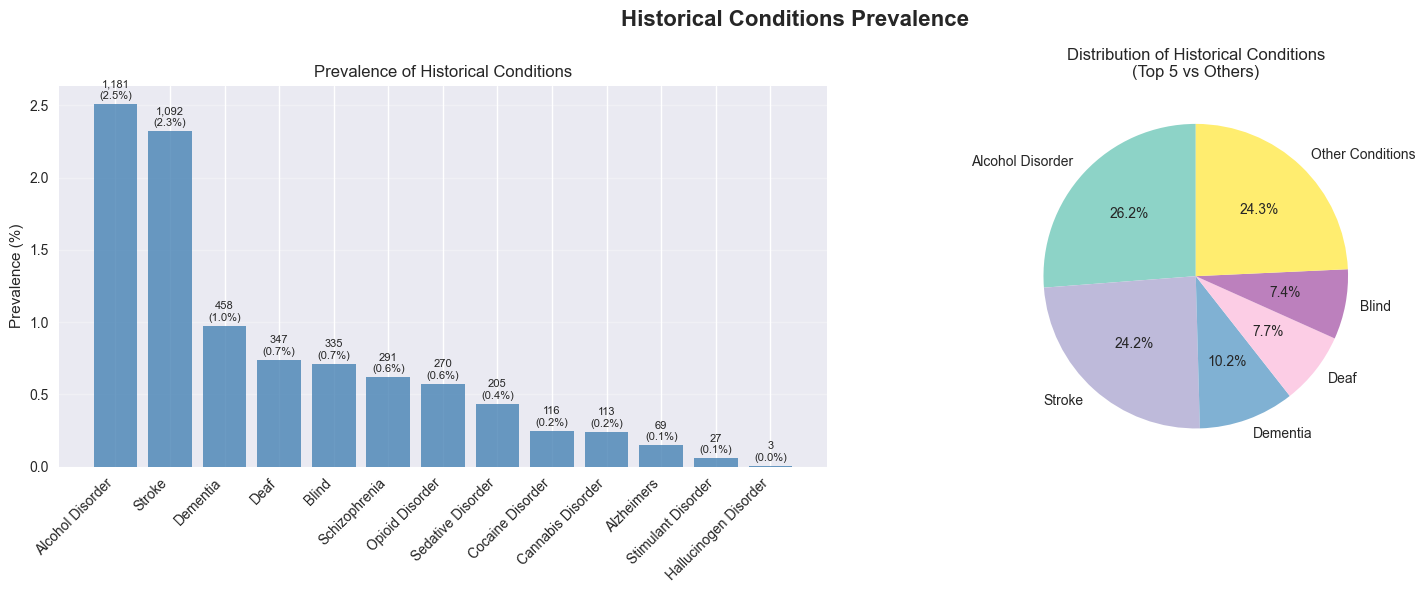

In [29]:
# Create prevalence visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Historical Conditions Prevalence', fontsize=16, fontweight='bold')

# Bar chart of prevalence
condition_names = list(hx_sorted.keys())
prevalences = [hx_sorted[name]['prevalence'] for name in condition_names]
counts = [hx_sorted[name]['count'] for name in condition_names]

bars = ax1.bar(range(len(condition_names)), prevalences, color='steelblue', alpha=0.8)
ax1.set_xticks(range(len(condition_names)))
ax1.set_xticklabels(condition_names, rotation=45, ha='right')
ax1.set_title('Prevalence of Historical Conditions')
ax1.set_ylabel('Prevalence (%)')
ax1.grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, (bar, count, prev) in enumerate(zip(bars, counts, prevalences)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02, 
             f'{count:,}\n({prev:.1f}%)', ha='center', va='bottom', fontsize=8)

# Pie chart for top conditions vs others
top_5_names = condition_names[:5]
top_5_counts = counts[:5]
other_count = sum(counts[5:])

pie_labels = top_5_names + ['Other Conditions']
pie_values = top_5_counts + [other_count]
colors = plt.cm.Set3(np.linspace(0, 1, len(pie_values)))

ax2.pie(pie_values, labels=pie_labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Distribution of Historical Conditions\n(Top 5 vs Others)')

plt.tight_layout()
plt.show()

In [30]:
# 2. Condition Co-occurrence Analysis
print("\nCondition Co-occurrence Analysis")
print("=" * 40)

# Create correlation matrix for historical conditions
hx_data = final_dataset[hx_columns].copy()
hx_corr = hx_data.corr()

# Calculate co-occurrence counts
co_occurrence = {}
for i, col1 in enumerate(hx_columns):
    for j, col2 in enumerate(hx_columns):
        if i < j:  # Only calculate upper triangle
            both_conditions = ((final_dataset[col1] == 1) & (final_dataset[col2] == 1)).sum()
            cond1_name = col1.replace('hx_', '').replace('_', ' ').title()
            cond2_name = col2.replace('hx_', '').replace('_', ' ').title()
            co_occurrence[f"{cond1_name} + {cond2_name}"] = both_conditions

# Sort by co-occurrence frequency
co_occurrence_sorted = dict(sorted(co_occurrence.items(), key=lambda x: x[1], reverse=True))

print("Top 10 condition pairs that co-occur:")
for i, (pair, count) in enumerate(list(co_occurrence_sorted.items())[:10], 1):
    total_patients = len(final_dataset)
    percentage = (count / total_patients) * 100
    print(f"  {i:2d}. {pair}: {count:,} patients ({percentage:.2f}%)")

# Number of conditions per patient
conditions_per_patient = final_dataset[hx_columns].sum(axis=1)
print(f"\nConditions per patient distribution:")
print(f"  No conditions: {(conditions_per_patient == 0).sum():,} patients ({(conditions_per_patient == 0).mean()*100:.1f}%)")
print(f"  1 condition: {(conditions_per_patient == 1).sum():,} patients ({(conditions_per_patient == 1).mean()*100:.1f}%)")
print(f"  2+ conditions: {(conditions_per_patient >= 2).sum():,} patients ({(conditions_per_patient >= 2).mean()*100:.1f}%)")
print(f"  Maximum conditions in one patient: {conditions_per_patient.max()}")


Condition Co-occurrence Analysis
Top 10 condition pairs that co-occur:
   1. Alcohol Disorder + Sedative Disorder: 187 patients (0.40%)
   2. Alcohol Disorder + Opioid Disorder: 82 patients (0.17%)
   3. Dementia + Stroke: 73 patients (0.16%)
   4. Deaf + Stroke: 70 patients (0.15%)
   5. Alzheimers + Dementia: 68 patients (0.14%)
   6. Opioid Disorder + Cocaine Disorder: 63 patients (0.13%)
   7. Alcohol Disorder + Stroke: 55 patients (0.12%)
   8. Alcohol Disorder + Cocaine Disorder: 53 patients (0.11%)
   9. Blind + Stroke: 38 patients (0.08%)
  10. Alcohol Disorder + Dementia: 37 patients (0.08%)

Conditions per patient distribution:
  No conditions: 43,497 patients (92.5%)
  1 condition: 2,773 patients (5.9%)
  2+ conditions: 778 patients (1.7%)
  Maximum conditions in one patient: 6


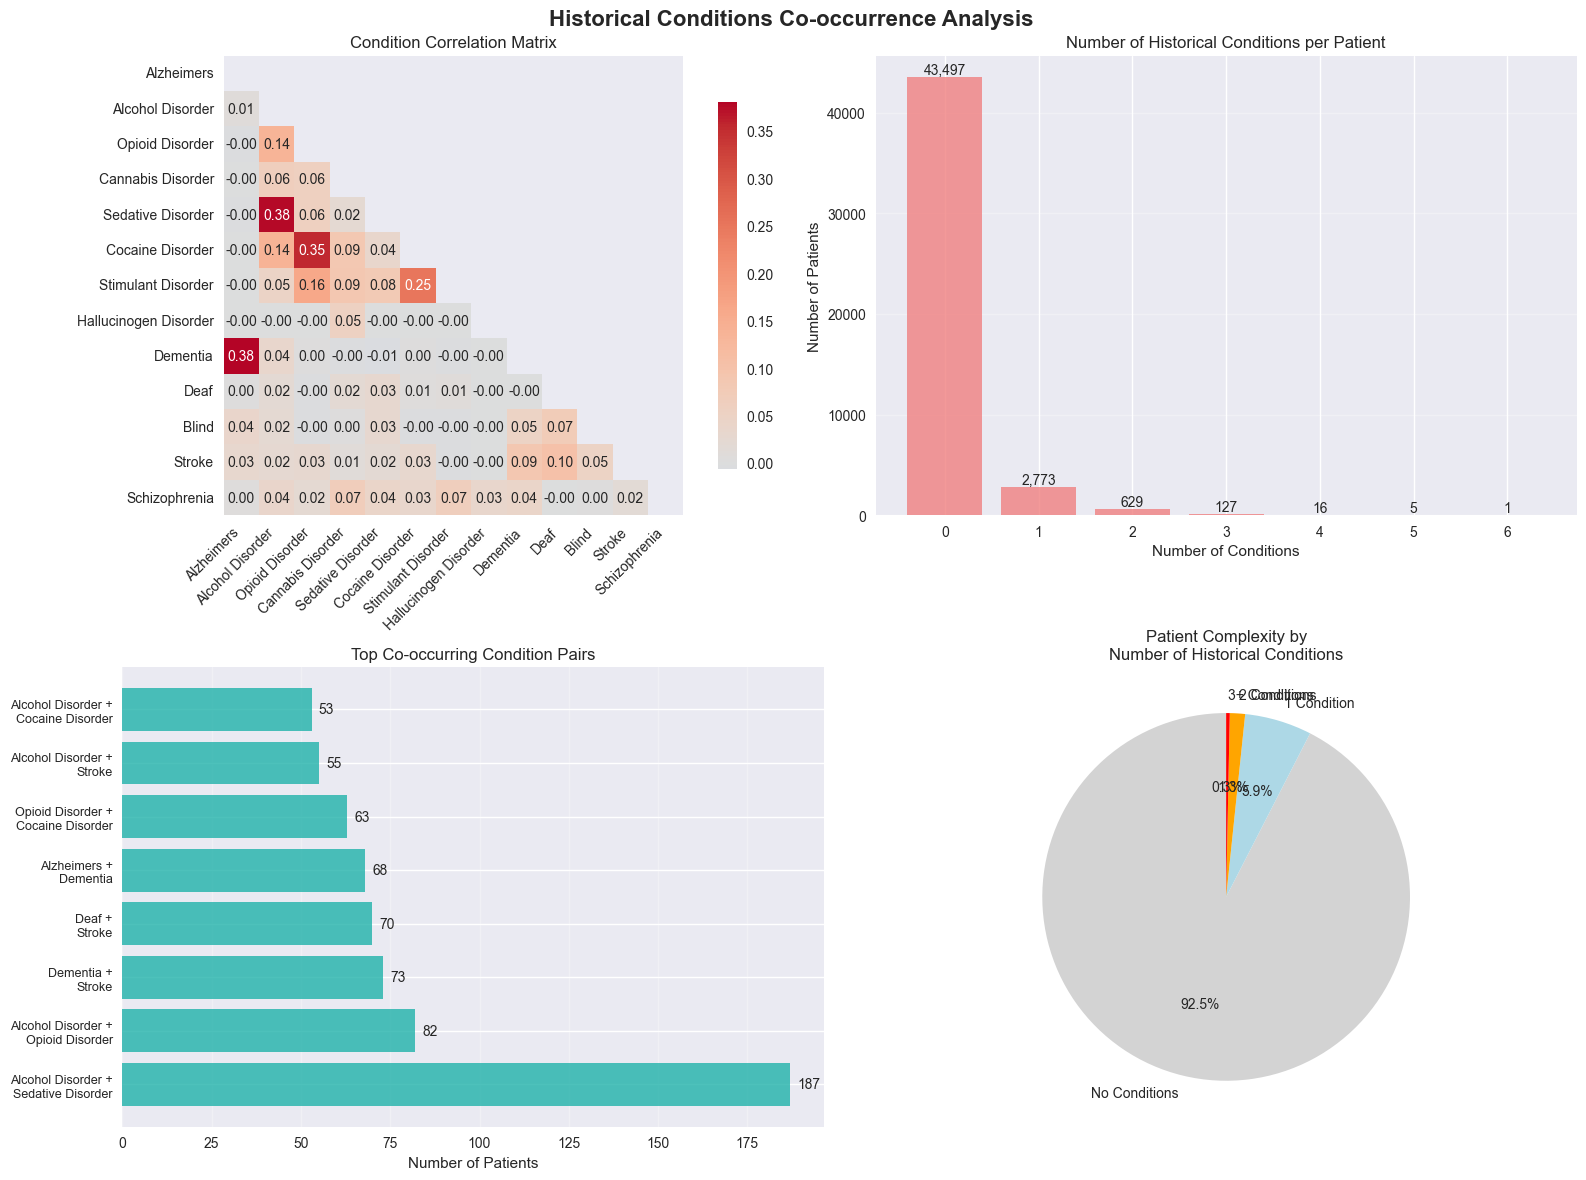

In [31]:
# Create co-occurrence visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Historical Conditions Co-occurrence Analysis', fontsize=16, fontweight='bold')

# 1. Correlation heatmap
ax1 = axes[0, 0]
clean_labels = [col.replace('hx_', '').replace('_', ' ').title() for col in hx_columns]
mask = np.triu(np.ones_like(hx_corr, dtype=bool))  # Mask upper triangle
sns.heatmap(hx_corr, mask=mask, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={"shrink": .8},
            xticklabels=clean_labels, yticklabels=clean_labels, ax=ax1)
ax1.set_title('Condition Correlation Matrix')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# 2. Number of conditions per patient
ax2 = axes[0, 1]
condition_counts = conditions_per_patient.value_counts().sort_index()
bars = ax2.bar(condition_counts.index, condition_counts.values, color='lightcoral', alpha=0.8)
ax2.set_title('Number of Historical Conditions per Patient')
ax2.set_xlabel('Number of Conditions')
ax2.set_ylabel('Number of Patients')
ax2.grid(axis='y', alpha=0.3)

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 20, 
             f'{int(height):,}', ha='center', va='bottom')

# 3. Top co-occurring pairs
ax3 = axes[1, 0]
top_pairs = list(co_occurrence_sorted.items())[:8]
pair_names = [pair[0] for pair in top_pairs]
pair_counts = [pair[1] for pair in top_pairs]

bars = ax3.barh(range(len(pair_names)), pair_counts, color='lightseagreen', alpha=0.8)
ax3.set_yticks(range(len(pair_names)))
ax3.set_yticklabels([name.replace(' + ', ' +\n') for name in pair_names], fontsize=9)
ax3.set_title('Top Co-occurring Condition Pairs')
ax3.set_xlabel('Number of Patients')
ax3.grid(axis='x', alpha=0.3)

# Add count labels
for i, (bar, count) in enumerate(zip(bars, pair_counts)):
    width = bar.get_width()
    ax3.text(width + 2, bar.get_y() + bar.get_height()/2., 
             f'{count}', ha='left', va='center')

# 4. Conditions distribution by complexity
ax4 = axes[1, 1]
complexity_labels = ['No Conditions', '1 Condition', '2 Conditions', '3+ Conditions']
complexity_counts = [
    (conditions_per_patient == 0).sum(),
    (conditions_per_patient == 1).sum(),
    (conditions_per_patient == 2).sum(),
    (conditions_per_patient >= 3).sum()
]

colors = ['lightgray', 'lightblue', 'orange', 'red']
wedges, texts, autotexts = ax4.pie(complexity_counts, labels=complexity_labels, 
                                   autopct='%1.1f%%', colors=colors, startangle=90)
ax4.set_title('Patient Complexity by\nNumber of Historical Conditions')

plt.tight_layout()
plt.show()